# How to read and analyse output from FOCI & FOCI-OpenIFS with FOCI Tools

Experiments
===========

* FOCI-SW222: ECHAM6 + NEMO3.6. Branch off from year 850 of a piControl. 1% CO2 increase per year.
* FOCI_GJK029: OpenIFS 43r3 + NEMO3.6. Branch off from year 700 of a piControl. 1% CO2 increase per year.

In [1]:
# Load the usual suspects
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean 

## Load FOCI Tools

Note: If you modify focitools you will need to restart your kernel! 

In [2]:
# Need to append the focitools path to the pythonpath
import sys
sys.path.append('/home/jkjellsson/notebooks/focitools/')

In [3]:
import focitools

## Configure Dask

In [4]:
from dask.distributed import Client, LocalCluster, wait

In [5]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33443 instead
  f"Port {expected} is already in use.\n"


In [6]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33443/status,
Dashboard: http://127.0.0.1:33443/status,Workers: 4
Total threads: 8,Total memory: 59.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35451,Workers: 4
Dashboard: http://127.0.0.1:33443/status,Total threads: 8
Started: Just now,Total memory: 59.60 GiB
Comm: tcp://127.0.0.1:45785,Total threads: 2
Dashboard: http://127.0.0.1:36917/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:44929,


## Specify what to read

In [22]:
# Where is the data located? 
# This is usually some directory named esm-experiments in the work or scratch directory
foci_dir = '/Projekte/fb1-me-foci/foci2.2/esm-experiments/'
focioifs_dir = '/Projekte/fb1-me-foci/focioifs/DECK/'

# List of all experiment IDs
foci_exps = ['FOCI2.2-SW222']
focioifs_exps = ['FOCI_GJK032_r3i1p1']

# List of the experiment names (this is just to label plots etc)
foci_names = ['FOCI-1pctCO2']
focioifs_names = ['FOCI-OpenIFS-1pctCO2']

# What times to read
times = [slice('1850-01-01','2000-01-01')]

## Read mesh information

The NEMO data is stored on the native tri-polar ORCA grid, so it is useful to save mesh information. 
This function will read the `mesh_mask.nc` file and do some simple processing to e.g. derive CMIP variables such as `areacello`, `masscello`. 

In [8]:
ds_mesh = focitools.read_nemo_mesh('/Projekte/fb1-me-foci/focioifs/mesh/mesh_mask.nc')

 Open NEMO mesh_mask file : 
/Projekte/fb1-me-foci/focioifs/mesh/mesh_mask.nc


## Read monthly ECHAM & OpenIFS data (surface)

ECHAM data is split into `ATM` and `BOT` files. 
* `ATM` contain 3D fields. 
* `BOT` contain 2D fields (this is the default to read)

OpenIFS data is split into `regular_sfc`, `regular_pl`, and `reduced_sfc`. 
* `regular_sfc` (2D fields, regular grid). Default to read
* `regular_pl` (3D fields, regular grid). 
* `reduced_sfc` (2D fields, native reduced Gaussian grid). 

Some OpenIFS may also include `regular_pv` (PV levels) and `regular_theta` (pot. temp. levels). 

In [9]:
# If no freq or grid is specified, we will read monthly 2D fields
ds_sfc_1m_foci = focitools.read_echam(foci_exps, times, foci_dir, freq='mm', grid='BOT')

/Projekte/fb1-me-foci/foci2.2/esm-experiments//FOCI2.2-SW222/outdata/echam/FOCI2.2-SW222*BOT*mm*.nc


In [23]:
# If no freq or grid is specified, we will read monthly 2D fields
ds_sfc_1m_focioifs = focitools.read_openifs(focioifs_exps, times, focioifs_dir, freq='1m', grid='regular_sfc')

/Projekte/fb1-me-foci/focioifs/DECK//FOCI_GJK032_r3i1p1/outdata/oifs/FOCI_GJK032_r3i1p1*1m*regular_sfc.nc


In [24]:
# Put both models into one list
ds_sfc_1m_all = ds_sfc_1m_foci + ds_sfc_1m_focioifs
exps_all = foci_exps + focioifs_exps
names_all = foci_names + focioifs_names

## Read monthly NEMO data - see other examples

## Read annual overturning streamfunctions from NEMO

A number of derived variables are computed from NEMO using CDFTOOLS (https://github.com/meom-group/CDFTOOLS). 
Examples in FOCI / FOCI-OpenIFS are: 
* Meridional overturning stream functions (MOC)
* Surface speed
* Barotropic stream function (PSI)
* Volume flux through straits

In [15]:
# Read MOC as (y,z) field as well as AMOC index at 25N and 45N
ds_amoc_foci = focitools.read_amoc(foci_exps, times, foci_dir)

In [25]:
# Repeat for FOCI-OpenIFS
ds_amoc_focioifs = focitools.read_amoc(focioifs_exps, times, focioifs_dir)

## Read transports

In [40]:
ds_trp_foci = focitools.read_transports(foci_exps, times, foci_dir)
ds_trp_focioifs = focitools.read_transports(focioifs_exps, times, focioifs_dir)

## Compute global-mean surface air temperature

In [26]:
# List for results
gmst_all = []

# Loop over each experiment 
for i, ds in enumerate( ds_sfc_1m_all ):
    
    if i == 0:
        # 2m air temp (tas in CMIP) is named temp2 in ECHAM6
        tas = ds['temp2']
    elif i == 1:
        # 2m air temp (tas in CMIP) is named 2t in OpenIFS
        tas = ds['2t']

    # Compute area-weighted global mean 
    gmst = focitools.area_mean(tas)
    
    # Compute annual mean
    gmst_ym = gmst.groupby('time.year').mean('time')
    
    # Xarray normally does lazy reading, so when you write e.g. 
    # tas.mean() it does not actually do any computing. 
    # By saying .compute() we force it to do all calculations now. 
    # So this command might take a while...
    gmst_all.append(gmst_ym.compute())

## Plot global-mean surface air temperature

Text(0.5, 1.0, 'Global-mean surface air temperature')

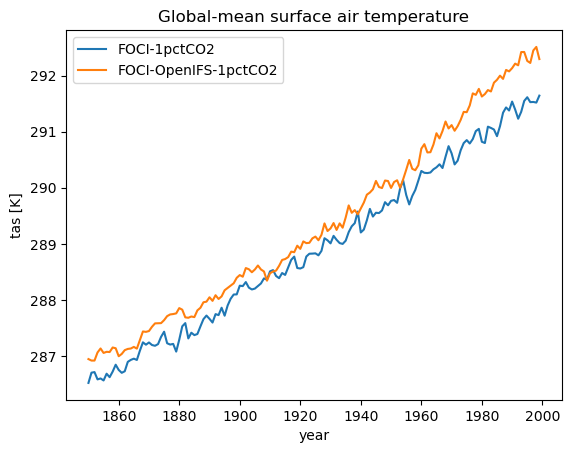

In [27]:
# Set up figure
fig1, ax1 = plt.subplots(1,1)

# Loop over all experiments 
for i, (gmst, name) in enumerate( zip(gmst_all, names_all) ):
    
    # Compute annual mean
    gmst.plot(ax=ax1, label=name)

# Draw legend, set labels
ax1.legend()
ax1.set_ylabel('tas [K]')
ax1.set_title('Global-mean surface air temperature')

## Plot AMOC changes

Text(0, 0.5, '[Sv]')

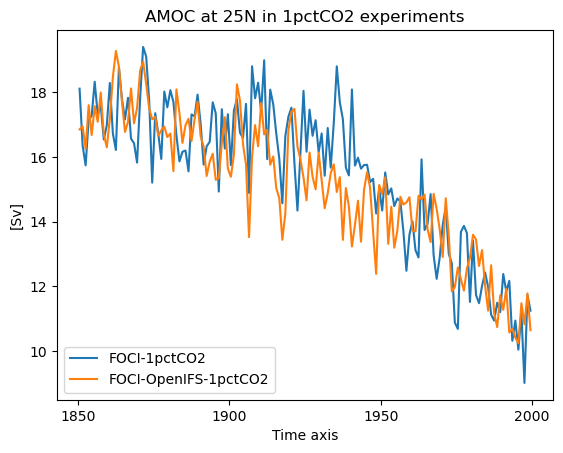

In [30]:
fig1, ax1 = plt.subplots(1,1)

for i, (ds_amoc, name) in enumerate( zip(ds_amoc_foci + ds_amoc_focioifs, names_all) ):
    
    # AMOC at 25N
    amoc25 = ds_amoc['amoc25']
    
    amoc25.plot(ax=ax1, label=name)
    
ax1.legend()
ax1.set_title('AMOC at 25N in 1pctCO2 experiments')
ax1.set_ylabel('[Sv]')

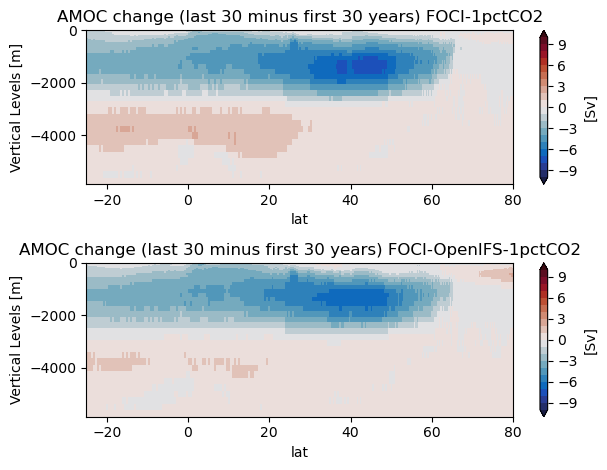

In [39]:
fig1, axs1 = plt.subplots(2, 1)

for i, (ds_amoc, name) in enumerate( zip(ds_amoc_foci + ds_amoc_focioifs, names_all) ):
    
    # Stream function
    amoc = ds_amoc['zomsfatl']
    
    # Last 30 years minus first 30 years
    diff = amoc.sel(time=slice('1970-01-01','2000-01-01')).mean('time') - \
           amoc.sel(time=slice('1850-01-01','1880-01-01')).mean('time')
    
    # Plot
    # Note: We have added latitude to the y axis, 
    # but latitude is not monotonically increasing
    # and some latitudes exist twice
    # We need to sortby lat first
    # Also, explicitly say we want lat and depth coords
    diff.sortby('lat').plot(ax=axs1[i], 
                            x='lat', y='depthw',
                            levels=np.linspace(-10,10,21),
                            cmap=cmocean.cm.balance,
                            cbar_kwargs={'label':'[Sv]', 'extend':'both'})
    
    axs1[i].set_title('AMOC change (last 30 minus first 30 years) %s' % (name,))
    
# Only focus on Atlantic
for ax in axs1:
    ax.set_xlim([-25, 80])
    
# Adjust figure to avoid overlapping axes
fig1.tight_layout()

## Plot changes in Denmark Strait

Text(0.5, 1.0, 'Denmark Strait transport')

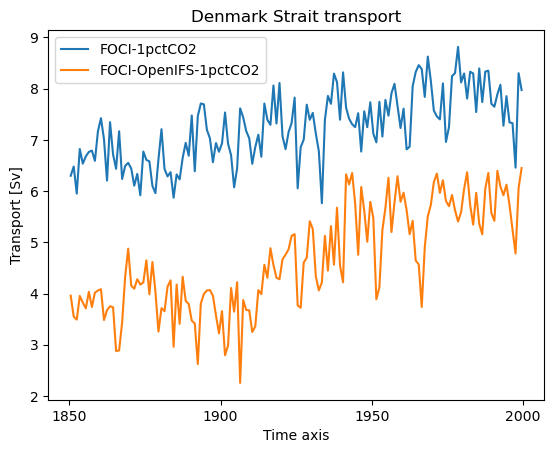

In [43]:
fig1, ax1 = plt.subplots(1, 1)

for i, (ds_trp, name) in enumerate( zip(ds_trp_foci + ds_trp_focioifs, names_all) ):
    
    # Get Denmark Strait flux
    denma = ds_trp['vtrp_denma']
    
    denma.plot(ax=ax1, label=name)
    
ax1.legend()
ax1.set_ylabel('Transport [Sv]')
ax1.set_title('Denmark Strait transport')